In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [136]:
df = pd.read_csv('weather_data.csv')

In [137]:
df = pd.DataFrame(df)

In [138]:
df.head(5)

,time,temp,wind_speed,wind_degree,pressure,precip,humidity,cloud,uv,weather
0,2023-12-31 00:00,26.9,2.2,225,29.82,0.00,79,42,0.0,1003
1,2023-12-31 01:00,26.7,2.5,240,29.81,0.00,80,32,0.0,1003
2,2023-12-31 02:00,26.6,2.9,255,29.79,0.01,80,77,0.0,1063
3,2023-12-31 03:00,26.4,3.2,233,29.79,0.01,81,87,0.0,1063
4,2023-12-31 04:00,26.3,3.6,218,29.79,0.00,81,36,0.0,1003


In [139]:
df.duplicated().sum()

0

In [140]:
training = df.drop(['time', 'weather', 'precip', 'uv'], axis=1)

In [141]:
training.head(5)

,temp,wind_speed,wind_degree,pressure,humidity,cloud
0,26.9,2.2,225,29.82,79,42
1,26.7,2.5,240,29.81,80,32
2,26.6,2.9,255,29.79,80,77
3,26.4,3.2,233,29.79,81,87
4,26.3,3.6,218,29.79,81,36


In [142]:
len(training)

8088

In [143]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# train_scaled = scaler.fit_transform(training)

In [144]:
pd.DataFrame(training).head(5)

,temp,wind_speed,wind_degree,pressure,humidity,cloud
0,26.9,2.2,225,29.82,79,42
1,26.7,2.5,240,29.81,80,32
2,26.6,2.9,255,29.79,80,77
3,26.4,3.2,233,29.79,81,87
4,26.3,3.6,218,29.79,81,36


In [145]:
def create_sequences(data, sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon):
        X.append(data[i:i + sequence_length, :])
        y.append(data[i + sequence_length:i + sequence_length + forecast_horizon, :])
        
    return np.array(X), np.array(y)

In [146]:
sequence_length = 6
forecast_horizon = 1

X, y = create_sequences(np.array(training), sequence_length, forecast_horizon)

In [147]:
split_ratio = 0.8
split = int(split_ratio * len(X))

x_train, x_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [206]:
num_features = X.shape[2]

model = tf.keras.Sequential([    
    tf.keras.layers.Input(shape=(sequence_length, num_features)),
    tf.keras.layers.LayerNormalization(),
    # tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.LayerNormalization(),
    # tf.keras.layers.Bidirectional(tf.keras.layers.GRU(48, return_sequences=False)),
    tf.keras.layers.GRU(48, return_sequences=False),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
    # tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
    # tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(num_features * forecast_horizon),  
    tf.keras.layers.Reshape((forecast_horizon, num_features))
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=['mean_absolute_error'])

In [207]:
# num_features = X.shape[2]

# x_input = tf.keras.layers.Input(shape=(sequence_length, num_features))
# x = scaler(x_input)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, return_sequences=True))(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(384, return_sequences=True))(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
# x = tf.keras.layers.Dense(192, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
# x = tf.keras.layers.Dense(num_features * forecast_horizon)(x)
# x_output = tf.keras.layers.Reshape((forecast_horizon, num_features))(x)

# model = tf.keras.models.Model(inputs=x_input, outputs=x_output)

# model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9), loss='mae', metrics=['mean_absolute_error'])

In [208]:
init_weights = model.get_weights()

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer_normalization             │ (None, 6, 6)           │            12 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 6, 64)          │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 6, 64)          │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 48)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 48)             │            96 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           102 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 6)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,674 (127.63 KB)

 Trainable params: 32,674 (127.63 KB)

 Non-trainable params: 0 (0.00 B)

In [209]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor = 0.5, patience=4, min_lr=1e-6)

In [210]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs):
        if logs['mean_absolute_error'] <= 5.5 and logs['val_mean_absolute_error'] <= 5.9:
            self.model.stop_training = True

custom_early_stopping = CustomEarlyStopping()

In [211]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [212]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, verbose=1, callbacks=[custom_early_stopping])
# history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, verbose=1, callbacks=[reduce_lr])

Epoch 1/100


404/404 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 43.7938 - mean_absolute_error: 41.2966 - val_loss: 13.5451 - val_mean_absolute_error: 11.4020
Epoch 2/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 12.7411 - mean_absolute_error: 10.5210 - val_loss: 9.9908 - val_mean_absolute_error: 7.7455
Epoch 3/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.2812 - mean_absolute_error: 7.0591 - val_loss: 9.1150 - val_mean_absolute_error: 6.9731
Epoch 4/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.3569 - mean_absolute_error: 6.2486 - val_loss: 8.7031 - val_mean_absolute_error: 6.6805
Epoch 5/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.0387 - mean_absolute_error: 6.0401 - val_loss: 8.4316 - val_mean_absolute_error: 6.5064
Epoch 6/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7.8572 - mean_absolute_error: 5.9508 - val_loss: 8.4381 - val_mean_absolute_error: 6.6046
Epoch 7/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.6423 - mean_absolute_error: 5.8229 - 

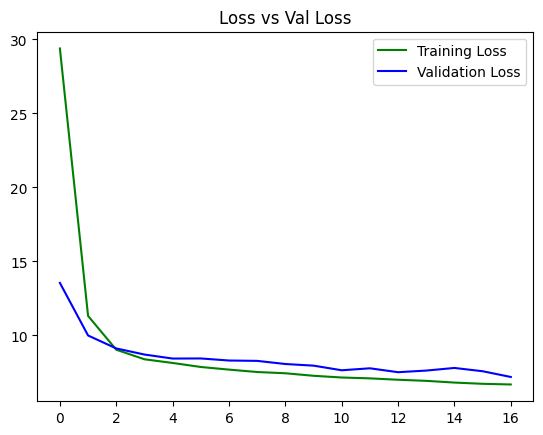

In [213]:
plt.plot(history.history['loss'], color='g', label='Training Loss')
plt.plot(history.history['val_loss'], color='b', label='Validation Loss')
plt.title("Loss vs Val Loss")
plt.legend()
plt.show()

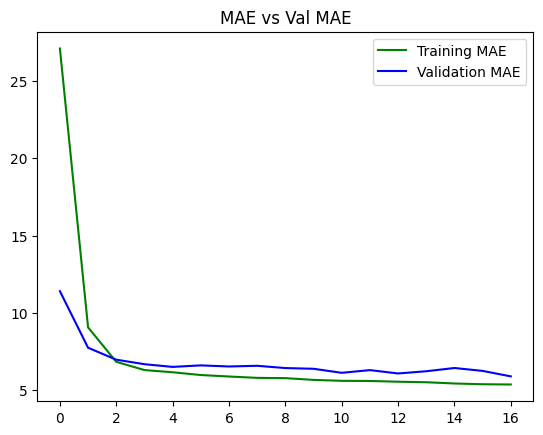

In [214]:
plt.plot(history.history['mean_absolute_error'], color='g', label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], color='b', label='Validation MAE')
plt.title("MAE vs Val MAE")
plt.legend()
plt.show()

In [215]:
loss, mae = model.evaluate(x_test, y_test, verbose=0)
print("Loss : {}, MAE : {}".format(loss, mae))

Loss : 7.186653137207031, MAE : 5.893240451812744


In [219]:
predictions = model.predict(x_test)

print(predictions[1])
print(y_test[1])

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[29.006542 11.606703 73.64549  29.171251 64.56573  75.02561 ]]
[[29.4  13.3  58.   29.77 63.   76.  ]]


In [218]:
# tf.keras.models.save_model(model, 'forecasting.keras')
# model.save("forecasting.keras")